In [183]:
import sys

sys.path.append('../../src')
import pandas
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve

In [184]:
# ======================================================================================================================
# Initialize Case Study
# ======================================================================================================================
_time_intervals = 10  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1  # Number of commodities                             (rho)
_exec_scenarios = 6  # Number of execution scenarios                     (chi)

M = 1e6  # Big M
loc1_capacity_factor = pandas.DataFrame(data={'com1_store10': [0,0,0,0,0,0], 'com1_store20': [1, 1, 0.5, 0, 0, 0], 'com1_procure': [1, 1, 0, 0, 0, 0]})
loc7_capacity_factor = pandas.DataFrame(data={'com1_store10': [1, 1, 1, 0.5, 0, 0], 'com1_store20': [0,0,0,0,0,0], 'com1_procure': [0,0,0,0,0,0]})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [185]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=50,
                    label='Commodity 1 consumed from outside the system')

com1 = Resource(name='com1', block={'imp': 1, 'urg': 1}, label='Commodity 1')

com1_sold = Resource(name='com1_sold', revenue=100.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [186]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='com1_procure', prod_max=M, conversion={com1_pur: -1, com1: 1}, capex=0, vopex=0, fopex=0,
                  label='Procure com1', varying=[VaryingProcess.DETERMINISTIC_CAPACITY])
com1_sell = Process(name='com1_sell', prod_max=M, conversion={com1: -1, com1_sold: 1}, capex=0, vopex=0, fopex=0,
                  label='Sell com1')
com1_store10 = Process(name='store110', storage=com1, store_max=10/_coms, prod_max=M, capex=100, vopex=1,
                  label="Storage capacity of 10 units", varying=[VaryingProcess.DETERMINISTIC_CAPACITY])
com1_store20 = Process(name='store120', storage=com1, store_max=20/_coms, prod_max=M, capex=200, vopex=2,
                  label="Storage capacity of 20 units", varying=[VaryingProcess.DETERMINISTIC_CAPACITY])
com1_store50 = Process(name='store150', storage=com1, store_max=50/_coms, prod_max=M, capex=500, vopex=5,
                  label="Storage capacity of 50 units")

In [187]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_store20}, label="Location 1", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, capacity_factor= {com1_store10: loc1_capacity_factor[['com1_store10']], com1_store20: loc1_capacity_factor[['com1_store20']], com1_procure: loc1_capacity_factor[['com1_procure']]})
loc2 = Location(name='loc2', processes={com1_store20}, label="Location 2", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)
loc3 = Location(name='loc3', processes={com1_store20}, label="Location 3", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)
loc4 = Location(name='loc4', processes={com1_store50}, label="Location 4", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)
loc5 = Location(name='loc5', processes={com1_store50, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)
loc6 = Location(name='loc6', processes={com1_procure, com1_store10}, label="Location 6", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)
loc7 = Location(name='loc7', processes={com1_store10}, label="Location 7", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, capacity_factor={com1_store10: loc7_capacity_factor[['com1_store10']], com1_store20: loc7_capacity_factor[['com1_store20']], com1_procure: loc7_capacity_factor[['com1_procure']]})

In [188]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20 = Transport(name='truck20', resources=[com1], trans_max=20, label='Truck with maximum capacity of 20 units',
                    trans_cost=0.02)
truck30 = Transport(name='truck30', resources=[com1], trans_max=30, label='Truck with maximum capacity of 30 units',
                    trans_cost=0.03)
truck40 = Transport(name='truck40', resources=[com1], trans_max=40, label='Truck with maximum capacity of 40 units',
                    trans_cost=0.04)
truck50 = Transport(name='truck50', resources=[com1], trans_max=50, label='Truck with maximum capacity of 50 units',
                    trans_cost=0.05)
truck100 = Transport(name='truck100', resources=[com1], trans_max=100, label='Truck with maximum capacity of 100 units',
                     trans_cost=0.1)

In [189]:
transport_matrix = [
    [[], [truck50], [truck30], [], [], [], []],  # sink: location 1
    [[truck50], [], [], [truck50], [truck30], [], []],  # sink: location 2
    [[truck30], [], [], [truck20], [], [], []],  # sink: location 3
    [[], [truck50], [truck20], [], [truck100], [truck50], [truck40]],  # sink: location 4
    [[], [truck30], [], [truck100], [], [], [truck40]],  # sink: location 5
    [[], [], [], [truck50], [], [], []],  # sink: location 6
    [[], [], [], [truck40], [truck40], [], []]  # sink: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

# ======================================================================================================================
# Declare network
# ======================================================================================================================
locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = list(locset)
sinks = list(locset)

network = Network(name='Network', source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix,
                  distance_matrix=distance_matrix)

In [190]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 110} if i == loc5 else {com1_sold: 0} for i in locset}

scenario = Scenario(name='scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0,
                    purchase_scale_level=0, availability_scale_level=0, demand_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario')

In [191]:
problem = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.TRANSPORT,
                                                    Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION,
                                                    Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq',
                    objective=Objective.PROFIT_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport imp cost
constraint transport cost
constraint transport cost network
constraint demand penalty
constraint network cost
constraint resource revenue
constraint location revenue
constraint network revenue
objective profit w demand penalty


In [192]:
problem.constraint_nameplate_production_varying_capacity.pprint()

constraint_nameplate_production_varying_capacity : restricts production to varying nameplate capacity
    Size=1260, Index=constraint_nameplate_production_varying_capacity_index, Active=True
    Key                            : Lower : Body                                                      : Upper : Active
    ('loc1', 'com1_procure', 0, 0) :  -Inf :     P[loc1,com1_procure,0,0] - Cap_P[loc1,com1_procure,0] :   0.0 :   True
    ('loc1', 'com1_procure', 0, 1) :  -Inf :     P[loc1,com1_procure,0,1] - Cap_P[loc1,com1_procure,0] :   0.0 :   True
    ('loc1', 'com1_procure', 0, 2) :  -Inf :     P[loc1,com1_procure,0,2] - Cap_P[loc1,com1_procure,0] :   0.0 :   True
    ('loc1', 'com1_procure', 0, 3) :  -Inf :     P[loc1,com1_procure,0,3] - Cap_P[loc1,com1_procure,0] :   0.0 :   True
    ('loc1', 'com1_procure', 0, 4) :  -Inf :     P[loc1,com1_procure,0,4] - Cap_P[loc1,com1_procure,0] :   0.0 :   True
    ('loc1', 'com1_procure', 0, 5) :  -Inf :     P[loc1,com1_procure,0,5] - Cap_P[loc1,co

In [193]:
results = solve(scenario=scenario, instance=problem, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 68467 rows, 79135 columns and 126784 nonzeros
Model fingerprint: 0x6985d2a8
Variable types: 77665 continuous, 1470 integer (1470 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Found heuristic solution: objective -660000.0000
Presolve removed 67312 rows and 76734 columns
Presolve time: 0.06s
Presolved: 1155 rows, 2401 columns, 5325 nonzeros
Variable types: 2401 continuous, 0 integer (0 binary)

Root relaxation: objective -3.442584e+05, 889 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

In [194]:
print([(key, value) for key, value in results.output['S'].items() if value != 0])

[(('loc5', 'com1_sold', 0, 0), 100.0), (('loc5', 'com1_sold', 0, 1), 100.0), (('loc5', 'com1_sold', 0, 2), 100.0), (('loc5', 'com1_sold', 0, 3), 100.0), (('loc5', 'com1_sold', 0, 4), 100.0), (('loc5', 'com1_sold', 0, 5), 100.0), (('loc5', 'com1_sold', 0, 6), 100.0), (('loc5', 'com1_sold', 0, 7), 100.0), (('loc5', 'com1_sold', 0, 8), 100.0), (('loc5', 'com1_sold', 0, 9), 100.0), (('loc5', 'com1_sold', 1, 0), 100.0), (('loc5', 'com1_sold', 1, 1), 100.0), (('loc5', 'com1_sold', 1, 2), 100.0), (('loc5', 'com1_sold', 1, 3), 100.0), (('loc5', 'com1_sold', 1, 4), 100.0), (('loc5', 'com1_sold', 1, 5), 100.0), (('loc5', 'com1_sold', 1, 6), 100.0), (('loc5', 'com1_sold', 1, 7), 100.0), (('loc5', 'com1_sold', 1, 8), 100.0), (('loc5', 'com1_sold', 1, 9), 100.0), (('loc5', 'com1_sold', 2, 0), 50.0), (('loc5', 'com1_sold', 2, 1), 50.0), (('loc5', 'com1_sold', 2, 2), 50.0), (('loc5', 'com1_sold', 2, 3), 50.0), (('loc5', 'com1_sold', 2, 4), 50.0), (('loc5', 'com1_sold', 2, 5), 50.0), (('loc5', 'com1_s

In [195]:
print([(key, value) for key, value in results.output['Inv'].items() if value != 0])

[(('loc1', 'store120_com1_stored', 0, 0), 2.0), (('loc1', 'store120_com1_stored', 0, 1), 4.0), (('loc1', 'store120_com1_stored', 0, 2), 6.0), (('loc1', 'store120_com1_stored', 0, 3), 8.0), (('loc1', 'store120_com1_stored', 0, 4), 10.0), (('loc1', 'store120_com1_stored', 0, 5), 12.0), (('loc1', 'store120_com1_stored', 0, 6), 14.0), (('loc1', 'store120_com1_stored', 0, 7), 16.0), (('loc1', 'store120_com1_stored', 0, 8), 18.0), (('loc1', 'store120_com1_stored', 0, 9), 20.0), (('loc1', 'store120_com1_stored', 1, 0), 20.0), (('loc1', 'store120_com1_stored', 1, 1), 20.0), (('loc1', 'store120_com1_stored', 1, 2), 20.0), (('loc1', 'store120_com1_stored', 1, 3), 20.0), (('loc1', 'store120_com1_stored', 1, 4), 20.0), (('loc1', 'store120_com1_stored', 1, 5), 20.0), (('loc1', 'store120_com1_stored', 1, 6), 20.0), (('loc1', 'store120_com1_stored', 1, 7), 20.0), (('loc1', 'store120_com1_stored', 1, 8), 20.0), (('loc1', 'store120_com1_stored', 1, 9), 20.0), (('loc1', 'store120_com1_stored', 2, 0), 20

In [196]:
print([(key, value) for key, value in results.output['Demand_penalty'].items() if value != 0])

[(('loc5', 'com1_sold', 2, 0), 50.0), (('loc5', 'com1_sold', 2, 1), 50.0), (('loc5', 'com1_sold', 2, 2), 50.0), (('loc5', 'com1_sold', 2, 3), 50.0), (('loc5', 'com1_sold', 2, 4), 50.0), (('loc5', 'com1_sold', 2, 5), 50.0), (('loc5', 'com1_sold', 2, 6), 50.0), (('loc5', 'com1_sold', 2, 7), 50.0), (('loc5', 'com1_sold', 2, 8), 50.0), (('loc5', 'com1_sold', 2, 9), 50.0), (('loc5', 'com1_sold', 3, 0), 30.0), (('loc5', 'com1_sold', 3, 1), 50.0), (('loc5', 'com1_sold', 3, 2), 50.0), (('loc5', 'com1_sold', 3, 3), 50.0), (('loc5', 'com1_sold', 3, 4), 50.0), (('loc5', 'com1_sold', 3, 5), 50.0), (('loc5', 'com1_sold', 3, 6), 50.0), (('loc5', 'com1_sold', 3, 7), 30.0), (('loc5', 'com1_sold', 3, 8), 50.0), (('loc5', 'com1_sold', 3, 9), 50.0), (('loc5', 'com1_sold', 4, 0), 50.0), (('loc5', 'com1_sold', 4, 1), 50.0), (('loc5', 'com1_sold', 4, 2), 50.0), (('loc5', 'com1_sold', 4, 3), 50.0), (('loc5', 'com1_sold', 4, 4), 50.0), (('loc5', 'com1_sold', 4, 5), 50.0), (('loc5', 'com1_sold', 4, 6), 50.0), 

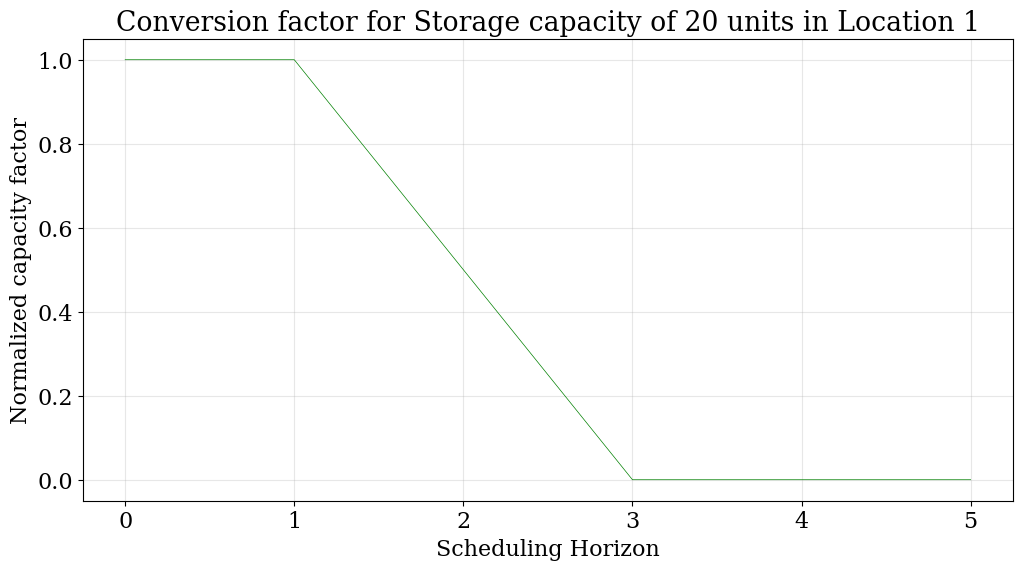

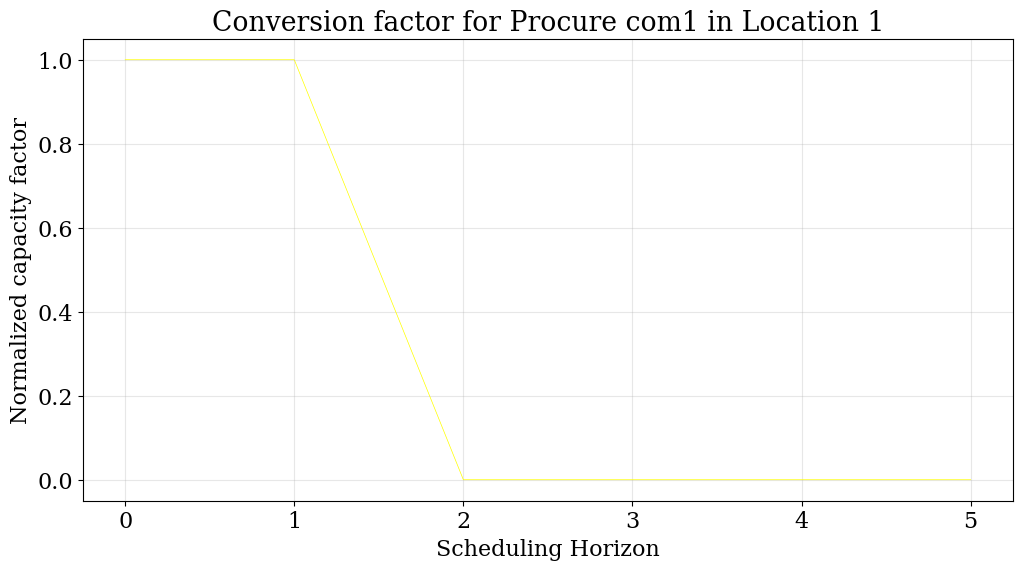

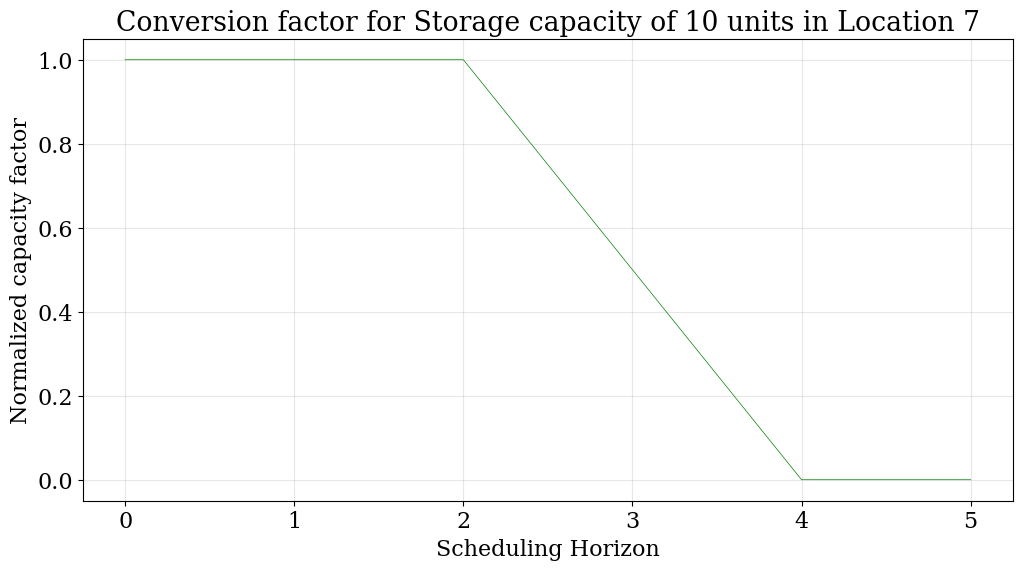

In [197]:
plot_location.capacity_factor(location=loc1, process=com1_store20, color='green')
plot_location.capacity_factor(location=loc1, process=com1_procure, color='yellow')
plot_location.capacity_factor(location=loc7, process=com1_store10, color='green')
# plot_location.availability_factor(resource=com1_pur,location=loc6,color='green')

In [198]:
print([(key, value) for key, value in results.output['C'].items() if value != 0 and key[0]=='loc1'])

[(('loc1', 'com1_pur', 0, 0), 54.0), (('loc1', 'com1_pur', 0, 1), 54.0), (('loc1', 'com1_pur', 0, 2), 54.0), (('loc1', 'com1_pur', 0, 3), 54.0), (('loc1', 'com1_pur', 0, 4), 54.0), (('loc1', 'com1_pur', 0, 5), 54.0), (('loc1', 'com1_pur', 0, 6), 54.0), (('loc1', 'com1_pur', 0, 7), 54.0), (('loc1', 'com1_pur', 0, 8), 54.0), (('loc1', 'com1_pur', 0, 9), 54.0), (('loc1', 'com1_pur', 1, 0), 53.0), (('loc1', 'com1_pur', 1, 1), 53.0), (('loc1', 'com1_pur', 1, 2), 53.0), (('loc1', 'com1_pur', 1, 3), 53.0), (('loc1', 'com1_pur', 1, 4), 53.0), (('loc1', 'com1_pur', 1, 5), 53.0), (('loc1', 'com1_pur', 1, 6), 53.0), (('loc1', 'com1_pur', 1, 7), 53.0), (('loc1', 'com1_pur', 1, 8), 53.0), (('loc1', 'com1_pur', 1, 9), 53.0)]


In [199]:
print([(key, value) for key, value in results.output['C'].items() if value != 0 and key[0]=='loc6'])

[(('loc6', 'com1_pur', 0, 0), 50.0), (('loc6', 'com1_pur', 0, 1), 50.0), (('loc6', 'com1_pur', 0, 2), 50.0), (('loc6', 'com1_pur', 0, 3), 50.0), (('loc6', 'com1_pur', 0, 4), 50.0), (('loc6', 'com1_pur', 0, 5), 50.0), (('loc6', 'com1_pur', 0, 6), 50.0), (('loc6', 'com1_pur', 0, 7), 50.0), (('loc6', 'com1_pur', 0, 8), 50.0), (('loc6', 'com1_pur', 0, 9), 50.0), (('loc6', 'com1_pur', 1, 0), 50.0), (('loc6', 'com1_pur', 1, 1), 50.0), (('loc6', 'com1_pur', 1, 2), 50.0), (('loc6', 'com1_pur', 1, 3), 50.0), (('loc6', 'com1_pur', 1, 4), 50.0), (('loc6', 'com1_pur', 1, 5), 50.0), (('loc6', 'com1_pur', 1, 6), 50.0), (('loc6', 'com1_pur', 1, 7), 50.0), (('loc6', 'com1_pur', 1, 8), 50.0), (('loc6', 'com1_pur', 1, 9), 50.0), (('loc6', 'com1_pur', 2, 0), 50.0), (('loc6', 'com1_pur', 2, 1), 50.0), (('loc6', 'com1_pur', 2, 2), 50.0), (('loc6', 'com1_pur', 2, 3), 50.0), (('loc6', 'com1_pur', 2, 4), 50.0), (('loc6', 'com1_pur', 2, 5), 50.0), (('loc6', 'com1_pur', 2, 6), 50.0), (('loc6', 'com1_pur', 2, 7)

In [200]:
print([(key, value) for key, value in results.output['P'].items() if value != 0 and key[0]=='loc7'])

[(('loc7', 'store110', 1, 0), 1.0), (('loc7', 'store110', 1, 1), 1.0), (('loc7', 'store110', 1, 2), 1.0), (('loc7', 'store110', 1, 3), 1.0), (('loc7', 'store110', 1, 4), 1.0), (('loc7', 'store110', 1, 5), 1.0), (('loc7', 'store110', 1, 6), 1.0), (('loc7', 'store110', 1, 7), 1.0), (('loc7', 'store110', 1, 8), 1.0), (('loc7', 'store110', 1, 9), 1.0), (('loc7', 'store110_discharge', 4, 8), 10.0)]


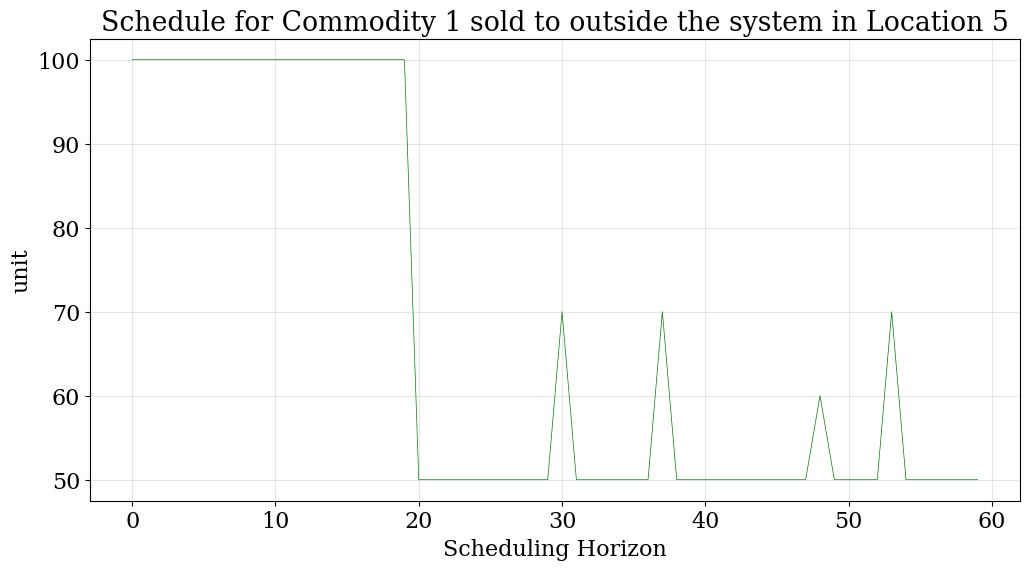

In [201]:
plot_results.schedule(results=results, y_axis='S', component='com1_sold', location='loc5', color='green')